# GPT-2 model architecture

This is an implementation of the GPT-2 architecture. It's based on [nanoGPT](https://github.com/karpathy/nanoGPT/blob/master/model.py) (Karpathy, 2022) with modifications and prose to make it easier for me to understand.

My key takeaways:

- The QKV values can be computed simultaneously, because V is the value that a token _would_ contribute if its key matched the query.
- The attention dimensions (QKV) are unrelated to the embedding dimension, but they are usually smaller than the embeddings.
- The sequence length is not an inhent part of the model, _except_ for the positional encodings. More recent schemes like RoPE make it possible to extend the context length after training¹.
- The output sequence $y$ is indeed the input sequence $x$ shifted by one. Therefore, the tokens are effectively shifted forward by the attention mechanism, and by the time they reach the final layer they have been shifted by one².


<details>
<summary style="opacity: 0.5">Footnotes</summary>
¹ Especially in conjunction normalization that forces model vectors only store direction (i.e. unit length) as in nGPT.

² I _think_ it should be possible to remove `lm_head` (the logits layer) and just decode the final embeddings directly into tokens
</details>

## Rotary positional encodings

Rotary positional encodings (RoPE) use quite a different scheme from earlier encodings schemes. GPT-2 (which nanoGPT replicates) uses learned embeddings, and the original Attention is All You Need paper used sinusoidal patterns — but in both cases, they were applied to the _input_ token embeddings. RoPE uses sinusoidal patterns, but they are used in attention space ($Q$, $K$) rather than input embedding space.

Crucially, RoPE applies sequence position information _as rotation_ of the queries and keys, rather than being simply added to the token embeddings. This means the attention mechanism can learn positional relationships in a way that is more compatible with the "direction-as-meaning" embeddings. It also generalises to longer sequences than were seen during training. However, that generalisation is still limited by the kind of normalisation that is applied in the `Block` (layer norm): layer norm is non-geometric, so it distorts the directional interpretation of the vectors.

The particular rotation used in RoPE is interesting: the vector components are rotated in pairs, where each pair is considered to be a 2D vector on a plane. The planes are all distinct, so while the embedding as a whole can be considered to be a single direction vector, it's not rotated as a whole (around another axis with as many dimensions). I wonder if doing so would improve things further?

In [1]:
import torch
import torch.nn as nn

class RotaryEncoding(nn.Module):
    def __init__(self, n_head_dim, base=10_000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, n_head_dim, 2).float() / n_head_dim))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, T, q, k):
        positions = torch.arange(T, device=self.inv_freq.device)
        freqs = positions.outer(self.inv_freq)
        enc = torch.cat((freqs, freqs), dim=-1)
        sin = torch.sin(enc)[None, None, :, :]
        cos = torch.cos(enc)[None, None, :, :]
        q = (q * cos) + (self._rotate_half(q) * sin)
        k = (k * cos) + (self._rotate_half(k) * sin)
        return q, k

    def _rotate_half(self, x):
        x1 = x[..., :x.shape[-1]//2]
        x2 = x[..., x.shape[-1]//2:]
        return torch.cat((-x2, x1), dim=-1)

## Causal self-attention

This module takes in a sequence of token-level embeddings (either from the previous layer or from the input), allows them to communicate with each other, and outputs new embeddings. The transformed embeddings are similar to the inputs, in that they exist in the same latent space, but each one now contains some context from tokens earlier in the sequence (Sanderson, 2024a). For example, if "the blue chair" was three tokens, then after passing through a self-attention layer the embeddings could have more nuanced meanings such as "the", "blue (as an adjective)", "chair (which is blue)".

### Attention as information retrieval

The attention mechanism works like a look-up table (LUT), where each token embedding can be used to "look up" contextual information. But unlike a regular LUT, this one looks up information from the entire sequence at once, weighting each earlier contribution by how much it is relevant to the current token. To do this, we first convert incoming embeddings to queries, keys and values ($q$, $k$, and $v$, per token):

- Queries _ask_ "Which earlier¹ tokens are relevant to me?"
- Keys _match_ "My token is relevant to later¹ queries that are like me"
- Values _offer_ "_If_ a later¹ query matches my key, here's the context I can provide..." (Sanderson, 2024a).

It's surprising that the value can be computed up-front, even before the queries have been compared to other tokens' keys! It's possible because the context that a token would provide is always the same, no matter what the query is — but the extent to which that value will be influence the output will depend on how closely the key matches the query.

All of this happens in a different latent space than the token embeddings. In particular:
- $Q$ and $K$ must share the same latent space, so that queries can be compared to keys. It need not be the same length as the token embeddings, and is usually much smaller.
- $V$ has its own latent space. It need not be the same length as the token embeddings or $Q$ and $K$, although in practice it's usually the same length as $Q$ and $K$.

### Attention heads

Reading the previous section, you might think that each token can only provide one piece of contextual information to later tokens. We get around that by doing the same thing multiple times, and then combining the results. We call the logical Q-K-V operation an "attention head", and package them up into an internal batch dimension called "head" so they can be computed in parallel.

<details>
<summary style="opacity: 0.5">Footnotes</summary>
¹ This is for causal self-attention. For cross-attention, all other tokens are queried.
</details>

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, n_head_dim, dropout):
        super().__init__()
        # attention dimensions:
        # - key and query dimensions need to be the same
        # - value dimension can be different, but in practice, we set it to the same thing
        self.n_kq = n_head_dim
        self.n_v = n_head_dim
        self.n_kq_tot = n_head * self.n_kq
        self.n_v_tot = n_head * self.n_v

        # projections from embedding dim to total attention dim (split into q, k, v) and back
        self.qkv = nn.Linear(n_embd, 2 * self.n_kq_tot + self.n_v_tot)
        self.proj = nn.Linear(self.n_v_tot, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.rotary_enc = RotaryEncoding(n_head_dim)

        self.n_head = n_head
        self.n_head_dim = n_head_dim
        self.scale = self.n_kq ** -0.5

    def _split_heads(self, tensor, batch_size, seq_len, n_head, n_head_dim):
        """Reshape tensor from (B, T, n_head * n_head_dim) into (B, n_head, T, n_head_dim)"""
        return tensor.view(batch_size, seq_len, n_head, n_head_dim).transpose(1, 2)

    def _merge_heads(self, tensor, batch_size, seq_len, n_head, n_head_dim):
        """Reshape tensor from (B, n_head, T, n_head_dim) into (B, T, n_head * n_head_dim)"""
        return tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, n_head * n_head_dim)

    def forward(self, x):
        B, T, C = x.shape

        # project all qkv matrices at once, then split
        qkv = self.qkv(x)
        q, k, v = qkv.split([self.n_kq_tot, self.n_kq_tot, self.n_v_tot], dim=-1)

        # reshape each of q, k, v from (B, T, n_head * n_head_dim) into (B, n_head, T, n_head_dim)
        q = self._split_heads(q, B, T, self.n_head, self.n_kq)
        k = self._split_heads(k, B, T, self.n_head, self.n_kq)
        v = self._split_heads(v, B, T, self.n_head, self.n_v)

        # Apply rotary encoding
        q, k = self.rotary_enc(T, q, k)

        # compute attention scores
        # 1. combine q and k to make a square matrix for query-key matching (relevance LUT)
        # 2. scale to 1/√n_kq, because otherwise the dot products grow with the number of dimensions
        # 3. causal masking
        # 4. scale relevance scores to add up to 1, so we can effectively add them up
        # 5. get the weighted contributions of all value embeddings according to their relevance
        att = (q @ k.transpose(-2, -1))
        att = att * self.scale
        att = att.masked_fill(torch.tril(torch.ones(T, T, device=att.device)) == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        y = att @ v

        # reshape output from (B, n_head, T, n_head_dim) into (B, T, n_head * n_head_dim)
        y = self._merge_heads(y, B, T, self.n_head, self.n_v)
        # project from attention embeddings back to token embeddings
        y = self.proj(y)
        return self.dropout(y)

## MLP

The multilayer perceptron (MLP) (aka feedforward layer) is an OG¹ deep learning pattern for nonlinear learned data transformations. That doesn't tell us much about what it does here but [3b1b has a great video on it](https://www.3blue1brown.com/lessons/mlp) (Sanderson, 2024). The structure of an MLP in a transformer does this:

1. First, it projects the input to a larger dimension (arbitrarily 4x the embedding size)
2. Apply GELU activation to introduce non-linearity, i.e. curves and bends that let the network learn more complex patterns, like a smooth switch.
3. Project back down to the original embedding size, to be compatible with later layers.

### What it does

Exactly what is going on in the large matrices that project up and then back down is anyone's guess. But essentially, it takes each embedding from the attention block — which by now contains contextual information from earlier embeddings in the sequence — and it _does knowledge_ to it. That is, it looks at the embedding and says something about it that it thinks will be useful for later layers. Note the subtlety in that last sentence: "something" is another embedding (that has meaning) and "will be useful" are both things that the MLP learned during training.

### What it doesn't

The MLP operates on each token embedding individually: at this point, there is no communication between tokens; that happens in the `CausalSelfAttention` module. Also, it does not _add_ knowledge to the embedding; it outputs an entirely new embedding, which is later added to the residual stream in the `Block`.

<details>
<summary style="opacity: 0.5">Footnotes</summary>
¹ From 1958!
</details>

In [3]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, n_embd, n_ff, dropout):
        super().__init__()
        # All operations maintain the batch and sequence length dimensions,
        # only transforming the embedding dimension.
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_ff),
            nn.GELU(),
            nn.Linear(n_ff, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

## Transformer block

A transformer "block":
1. Uses multi-headed attention to pass context between tokens (see _Causal self-attention_, above)
2. Adds the attention output back to the original embeddings (residual connection)
3. Adds the knowledge it has learned to the contextualized tokens with a simple feed-forward network (see _Multilayer perceptron_, above)
4. Adds the MLP output back to its input (another residual connection)

Layer normalization is applied before each sub-module to keep activations well-behaved during training.

These blocks are then stacked as "layers"; see _GPT_ below.

### Residual connection

The residual stream has a couple of motivations. Numerically, it's needed so that the gradients can propagate all the way back through the network. Without it, earlier layers would struggle to learn anything. What's more interesting is that it allows some of the original information to flow past each layer — otherwise, the meaning of the token would be completely replaced by whatever the attention mechanism thought was useful, which may starve later layers of the information _they_ need.

In [4]:
import torch.nn as nn
from torch.nn import functional as F

class Block(nn.Module):
    def __init__(self, n_embd, n_head, n_head_dim, n_ff, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_head, n_head_dim, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, n_ff, dropout)

    def forward(self, x):
        # x+ is the residual connection
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

## Decoder-only transformer

Here we tie together all the previous modules into "the transformer". Having discussed those other pieces already, this part is straightforward. The GPT module:

1. Prepares the input embeddings:
   - Converts token indices to the learned embeddings with a literal look-up table
   - Adds additional embeddings for the position of each token within the sequence (elementwise addition, i.e. without any extra embedding dimensions)
2. Pushes those embeddings through the transformer blocks (layers), one after the other
3. Normalizes and projects the output embeddings to logits.

### Interpretation of the logits

During training, the "labels" $y$ are the same as the input sequence $x$ but shifted by one (so that $y_t=x_{t+1}$). The output logits have a length equal to the vocabulary size¹, so we can interpret them as meaning "the likelihood that token $k$ comes next". This isn't intrinsic to logits: we cause them to have this meaning when we define the loss function. However, the loss is not an intrinsic part of the model, and it's actually specified in the training code further down.

With the logits defined like this, generation is simple: we could just pick the most likely token (corresponding to the logit with the highest value) and output that. That would produce fairly formulaic text, though, so we convert the logits to a probability distribution (using softmax) and sample from it.

<details>
<summary style="opacity: 0.5">Footnotes</summary>
¹ I.e. the number of distinct token values.
</details>

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class GPT(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_head_dim, n_ff, n_layer, dropout=0.0, block_size=1024):
        super().__init__()
        self.block_size = block_size

        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(vocab_size, n_embd),
            'wpe': nn.Embedding(block_size, n_embd),  # max sequence length
            'blocks': nn.ModuleList([Block(n_embd, n_head, n_head_dim, n_ff, dropout) for _ in range(n_layer)]),
            'ln_f': nn.LayerNorm(n_embd)
        })
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # tie weights between embedding and LM head
        self.transformer.wte.weight = self.lm_head.weight

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def forward(self, idx):
        B, T = idx.shape

        # token + position embeddings
        pos = torch.arange(T, device=idx.device)
        x = self.transformer.wte(idx) + self.transformer.wpe(pos)

        # transformer blocks
        for block in self.transformer.blocks:
            x = block(x)

        # decoder head
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        return logits

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    @torch.no_grad()
    def generate(self, tok_idx, max_new_tokens, temperature=1.0):
        # Initialize metrics arrays
        # We'll align everything to input length + max_new_tokens
        total_len = tok_idx.size(1) + max_new_tokens
        device = tok_idx.device
        entropies = torch.full((total_len,), float('nan'), device=device)
        perplexities = torch.full((total_len,), float('nan'), device=device)

        # Calculate perplexity for the prompt (except first token)
        if tok_idx.size(1) > 1:
            logits = self.forward(tok_idx)
            targets = tok_idx[:, 1:]  # shifted right
            losses = F.cross_entropy(logits[:, :-1].view(-1, logits.size(-1)),
                                   targets.view(-1), reduction='none')
            # Fill in perplexities for prompt tokens (starting at position 1)
            perplexities[1:tok_idx.size(1)] = torch.exp(losses)

        # Generate tokens and track metrics
        curr_len = tok_idx.size(1)
        for _ in range(max_new_tokens):
            # Get context within block size
            inputs = tok_idx[:, -self.block_size:]
            logits = self.forward(inputs)

            # Get next token logits and apply temperature
            next_token_logits = logits[:, -1] / temperature

            # Compute probabilities and entropy for next token
            probs = F.softmax(next_token_logits, dim=-1)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            entropies[curr_len] = entropy

            # Sample next token
            idx_next = torch.multinomial(probs, num_samples=1)

            # Calculate perplexity for the generated token
            if curr_len > 0:
                token_loss = F.cross_entropy(next_token_logits,
                                           idx_next.view(-1), reduction='none')
                perplexities[curr_len] = torch.exp(token_loss)

            # Append to sequence and increment position
            tok_idx = torch.cat([tok_idx, idx_next], dim=1)
            curr_len += 1

        return {
            'tokens': tok_idx,
            'perplexities': perplexities,
            'entropies': entropies
        }

## Adjustable sequence length<span id="smidgin-len"></span>

It's interesting that most of the module constructor parameters say nothing about the sequence length. For example, the self-attention constructor is defined as:

```python
def __init__(self, n_embd, n_head, n_head_dim, dropout):
    ...
```

The layer weight matrices are created in `__init__`, which means they are **broadcast** over the batch $B$ and sequence $T$ dimensions are determined at train/test time in the forward pass:

```python
def forward(self, x):
    B, T, C = x.shape
    ...
```

This is surprising to me: I knew the batche size could be varied after training, but this means the sequence length could also be varied. This is true for the whole network, except for the final `GPT` module, which learns positional encodings with an Embedding layer:

```python
self.transformer = nn.ModuleDict({
    'wpe': nn.Embedding(block_size, n_embd),
    ...
```

Since the encodings are learned, the number of embeddings must be set before training.

I've heard the rotary positional encodings (RoPE) work a little better with longer sequences after training, and that hypersphere normalization helps even more (Loshchilov et. al, 2024), and now I think I understand why.

# Data

We'll grab a small dataset. It's just one big block of text from which we take random substrings. These may overlap, but we aim to take roughly the entire corpus on each epoch.

Of note: the "labels" $y$ are the same as the input values $x$, shifted by one, since we want to predict each next token.

```python
x = self.data[idx:idx + self.block_size]
y = self.data[idx + 1:idx + self.block_size + 1]
```

In [ ]:
import math
import torch
from torch.utils.data import Dataset, RandomSampler

class CharTokenizer:
    def __init__(self, vocabulary: str):
        """
        A simple character-level tokenizer.

        Args:
            vocabulary: string of unique characters to use as vocabulary
        """
        vocabulary = set(vocabulary)
        self.vocabulary = sorted(vocabulary)
        self.vocab_size = len(self.vocabulary)
        self.stoi = {ch:i for i,ch in enumerate(self.vocabulary)}
        self.itos = {i:ch for i,ch in enumerate(self.vocabulary)}

    def encode(self, string: str):
        return [self.stoi[c] for c in string]

    def decode(self, tokens):
        return ''.join([self.itos.get(i, '') for i in tokens])

class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size - 1

    def __getitem__(self, idx: int):
        x = self.data[idx:idx + self.block_size]
        y = self.data[idx + 1:idx + self.block_size + 1]
        return x, y

class OverlappingRandomSampler(RandomSampler):
    def __init__(self, data_source, batch_size, seq_len, oversample=1):
        super().__init__(data_source, replacement=True, num_samples=math.ceil(len(data_source) * oversample / batch_size / seq_len))

In [ ]:
import ftfy
import requests
import torch
from torch.utils.data import DataLoader

def download_the_scarlet_pimpernel():
    url = 'https://www.gutenberg.org/cache/epub/60/pg60.txt'
    response = requests.get(url)
    response.raise_for_status()
    text = response.text.replace('\r\n', '\n')
    text = text[text.find('\nCHAPTER I.') : text.rfind('*** END OF THE PROJECT GUTENBERG EBOOK')].strip()
    # Normalize text to avoid weird quotation marks etc.
    text, explanation = ftfy.fix_and_explain(text)
    metadata = {
        'title': 'The Scarlet Pimpernel',
        'url': url,
        'fixes': explanation,
        'total_chars': len(text),
        'vocab_size': len(set(text)),
    }
    return text, metadata

def tokenize_data(sources: list[tuple[str, dict]]):
    text = ''.join([source[0] for source in sources])
    # Create character-level encoder/decoder specific to this dataset.
    tokenizer = CharTokenizer(text)
    data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
    metadata = {
        'vocabulary': tokenizer.vocabulary,
        'vocab_size': tokenizer.vocab_size,
        'total_chars': len(text),
        'sources': [source[1] for source in sources],
    }
    return data, metadata

def get_dataloader(data, data_config, model_config):
    n = int(data_config['train_split'] * len(data))
    train_dataset = TextDataset(data[:n], model_config['block_size'])
    val_dataset = TextDataset(data[n:], model_config['block_size'])
    train_loader = DataLoader(
        train_dataset,
        batch_size=data_config['batch_size'],
        sampler=OverlappingRandomSampler(train_dataset, data_config['batch_size'], model_config['block_size'], oversample=2)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=data_config['batch_size'],
        sampler=OverlappingRandomSampler(val_dataset, data_config['batch_size'], model_config['block_size'])
    )
    return train_loader, val_loader

# Training

## Training utils

Optimizer: Use an Adam with weight decay (AdamW) for SGD.

We only want to apply weight decay to weight matrices — not biases or scalar parameters. It so happens that we can distinguish these with a simple test:
- Weight matrices (e.g. in Linear and Embedding layers) are at least rank 2
- Bias and scale vectors are rank 1, and scalars¹ are rank 0.

This may look fragile, but it's actually quite robust: it captures the fundamental difference between weight matrices and bias vectors without relying on naming conventions².

<details>
<summary style="opacity: 0.5">Footnotes</summary>
¹ In practice, we don't have any scalars.

² If the architecture did have a low-rank tensor that we wanted to apply
</details>

In [ ]:
from torch.optim import AdamW

def configure_optimizer(model, weight_decay, learning_rate, betas):
    # apply weight decay to weight matrices (2+D tensors) but not to biases/scales (1-D tensors)
    params = [p for n, p in model.named_parameters() if p.requires_grad]
    decay_params = [p for p in params if p.dim() >= 2]
    nodecay_params = [p for p in params if p.dim() < 2]

    optim_groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]

    return AdamW(optim_groups, lr=learning_rate, betas=betas)

Learning rate schedule: Linear warmup and then cosine decay, so that:
- The parameters don't get jolted at the start by a high learning rate
- Learning steps become finer as we approach the bottom of the basin in the loss landscape (although for simplicity we don't measure that, and we just assume that we'll be somewhere near the bottom of a basin near the final epoch).

In [ ]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

def configure_scheduler(optimizer, warmup_steps, total_steps):
    import warnings
    warnings.filterwarnings("ignore", message=r".*The epoch parameter in.*scheduler.step", category=UserWarning)

    # Create schedulers for each phase
    warmup_scheduler = LinearLR(
        optimizer,
        start_factor=0.01,
        total_iters=warmup_steps
    )
    return warmup_scheduler

    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=total_steps - warmup_steps,
        eta_min=0.1
    )

    # Combine them sequentially
    return SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[warmup_steps]
    )

Miscellany

In [ ]:
from contextlib import contextmanager
import math
import torch.nn as nn

@contextmanager
def eval(model: nn.Module):
    """Sets the model to evaluation mode. Complements torch.no_grad"""
    training_state = model.training
    model.eval()
    yield
    model.train(training_state)

def align(x: int, y: int) -> int:
    """Align x to the nearest multiple of y"""
    return int(math.ceil(x / y) * y)

# Compute

Set up the things we'll need for remote compute. We do this before defining the pipelines so we can play with them as we go, notebook-style.

In [ ]:
from pathlib import Path
import modal

from utils.requirements import freeze

image = (
    modal.Image.debian_slim()
    .pip_install(*freeze('torch', 'requests'))
    .add_local_python_source('utils')
)

project_name = 'nanogpt-rope'
data_dir = Path('/data')
volume = modal.Volume.from_name(project_name, create_if_missing=True)
app = modal.App(
    project_name,
    image=image,
    volumes={data_dir: volume},
)

TypeError: sequence item 0: expected str instance, int found

In [ ]:
import json

from utils.modal import run

prepared_data_path = data_dir / 'processed'

def save_data(data, metadata, path):
    path.mkdir(parents=True, exist_ok=True)
    torch.save(data, path / 'tokenized.pt')
    with open(path / 'metadata.json', 'w') as f:
        json.dump(metadata, f)

@app.function()
def prepare_data():
    sources = [
        download_the_scarlet_pimpernel(),
    ]
    data, metadata = tokenize_data(sources)
    save_data(data, metadata, prepared_data_path)
    return metadata

async with run(app):
    input_metadata = await prepare_data.remote.aio()
    print(input_metadata)

In [ ]:
def load_data(path):
    data = torch.load(path / 'tokenized.pt')
    with open(path / 'metadata.json', 'r') as f:
        metadata = json.load(f)
    return data, metadata

def load_dataloaders(path, data_config, model_config):
    data, metadata = load_data(path)
    if torch.cuda.is_available():
        data = data.cuda()
    train_loader, val_loader = get_dataloader(data, data_config, model_config)
    tokenizer = CharTokenizer(metadata['vocabulary'])
    return train_loader, val_loader, tokenizer

## ... Actually training

In [ ]:
# Model hyperparameters
model_config = {
    'vocab_size': align(input_metadata['vocab_size'], 64),  # Discovered during data prep
    'block_size': 512,  # maximum sequence length
    'n_embd': 32,       # embedding dimension
    'n_head': 8,        # number of attention heads
    'n_head_dim': 8,    # qkv dimension per-head, can be any size, rule of thumb: n_embd // n_head.
    'n_ff': 128,        # number of dimensions in the MLP, rule of thumb: 4 * n_embd
    'n_layer': 15,      # number of transformer blocks
    'dropout': 0.2,
}
criterion = nn.CrossEntropyLoss()

# Training hyperparameters
data_config = {
    'batch_size': 8,
    'oversample': 1,
    'train_split': 0.8,
}
optimizer_config = {
    'weight_decay': 1e-1,
    'learning_rate': 0,  # Tuned by LR finder
    'betas': (0.9, 0.95),
}

number of parameters: 0.26M


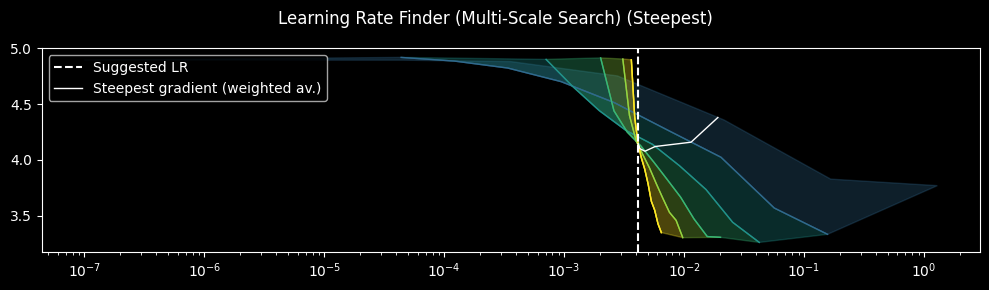

  0%|          | 0/60 [00:00<?, ?it/s]

Suggested Learning Rate: 4.13e-03


In [ ]:
from utils import LRFinder

@app.function(gpu='T4')
def find_learning_rate():
    model = GPT(**model_config)
    if torch.cuda.is_available():
        model = model.to('cuda')

    optimizer = configure_optimizer(model, **optimizer_config)
    lr_finder = LRFinder(model, criterion, optimizer=optimizer)

    train_loader, _, _ = load_dataloaders(prepared_data_path, data_config, model_config)

    suggested_lr = lr_finder.range_test(
        train_loader,
        start_lr=1e-7,
        end_lr=1e+1,
        num_zooms=6,  # Number of zoom levels
        steps_per_zoom=10,
        zoom_factor=0.5,  # Controls zoom window size
        method='steepest',
    )
    return suggested_lr

async with run(app):
    suggested_lr = await find_learning_rate.remote.aio()

print(f"Suggested Learning Rate: {suggested_lr:.2e}")

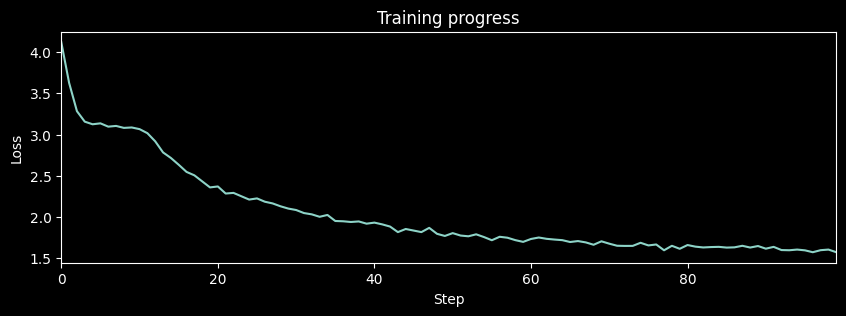

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Step:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
from utils import loss_chart

epochs           = 100
# epochs           = 20
lr_warmup_epochs = 10

# Optimizer

optimizer = configure_optimizer(
    model,
    weight_decay=1e-1,
    learning_rate=suggested_lr,
    betas=(0.9, 0.99),
)
scheduler = configure_scheduler(optimizer, lr_warmup_epochs * len(train_loader), total_steps=epochs * len(train_loader))

# Training loop

plot = loss_chart(epochs)
pb_epoch = tqdm(range(epochs), desc="Epoch")
pb_step = tqdm(total=len(train_loader) + len(val_loader), desc="Step", leave=False)
for _ in pb_epoch:
    pb_step.reset()
    for xb, yb in train_loader:
        pb_step.update(1)
        logits = model(xb)
        loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

    total_val_loss = 0
    with eval(model), torch.no_grad():
        for xb, yb in val_loader:
            pb_step.update(1)
            logits = model(xb)
            loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
            total_val_loss += loss.item()

    metrics = dict(
        val_loss=total_val_loss / len(val_loader),
        lr=optimizer.param_groups[0]['lr']
    )
    plot(metrics['val_loss'])
    pb_epoch.set_postfix(metrics)
pb_step.close()

# Generate continuations

In [ ]:
prompt = "Odd's fish m'dear,"
context = torch.tensor([encode(prompt)], dtype=torch.long)
if torch.cuda.is_available():
    context = context.cuda()

match model.generate(context, max_new_tokens=500, temperature=0.5):
    case {'tokens': tokens, 'perplexities': perplexities, 'entropies': entropies}: pass
generation = decode(tokens[0].cpu().tolist())
print(generation[:40], '(etc.)')

Odd's fish m'dear, with the own to see o (etc.)


### Token metrics: Perplexity and entropy

Let's visualize the generation along with some metrics:
* **Entropy** is how diffuse the probability distribution is for the next token, i.e. the spread of probabilities before sampling. Can be thought of as how uncertain the model is about what to say next. This usually isn't calculated for prompt tokens.
* **Perplexity** is how unlikely the next token is. Can be thought of as how surprised the model is by the presence of the token at this point in the sequence. This is usually calculated for prompt tokens, but can also be calculated for continuation tokens.

```python
# For entropy (uncertainty about next token):
probs = F.softmax(next_token_logits, dim=-1)
entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)

# For perplexity (surprise about actual token):
token_loss = F.cross_entropy(next_token_logits, idx_next.view(-1), reduction='none')
perplexities[curr_len] = torch.exp(token_loss)
```

Notably, _the entropy of continuation tokens is unaffected by temperature_, whereas the perplexity _is_ affected (because it's calculated after sampling).

We should expect them to be correlated, because when the model is very certain (low entropy), it's more likely to sample a high-probability token (low perplexity), and vice-versa. But they can diverge in interesting ways: You could have high entropy but still sample a high-probability token by chance (high entropy, low perplexity), or You could have low entropy but sample an unlikely token due to temperature (low entropy, high perplexity).

In [ ]:
from utils import text_metrics_vis
viz = text_metrics_vis(chars_per_line=80, vocab_size=vocab_size)
viz.visualize(generation, perplexities.cpu(), entropies.cpu())

# Future research

### Temperature as a resource

It's interesting to note that the first character of each word is high entropy and high perplexity, and subsequent characters are lower. And where the model makes spelling mistakes, it often had low entropy but then high perplexity! Which suggests that it knows what it wants to write, but the sampling mechanism is messing it up.

I'd like to see if it improves to lower the temperature after the first letter of each word. How would that generalise to languages that don't use spaces? Perhaps the temperature could be a resource that gets used (by picking unlikely tokens) and gradually replenished (by picking likely ones). Yeah that could be really cool!

# References

Karpathy, A. (2022). nanoGPT [Computer software]. GitHub. https://github.com/karpathy/nanoGPT

Sanderson, G. (2024a). Visualizing attention, a transformer's heart. 3Blue1Brown. https://www.3blue1brown.com/lessons/attention

Sanderson, G. (2024b). How might LLMs store facts. 3Blue1Brown. https://www.3blue1brown.com/lessons/mlp

# Software Licenses

The code in this notebook is derived from nanoGPT (Karpathy, 2022), which is licensed under the MIT License, Copyright (c) 2022 Andrej Karpathy.